In [99]:
# from lambert's algorithm we find that the ideal launch date is : 07 september 2022 and arrival at 27 march 2023
# at launch, mars is 40.33 degrees
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
G = 6.6726e-11   #Grav constant
dt=200  #timestep size
n=86236  #  86391 for dt=200 based on theorteical transfer time 86810     #[10847.    3658.75] 445563990
i=0 #for the loop later
PI=np.pi

class Planet:
    def __init__(self, name, mass, dist, radius, period,theta):
        self.name=name
        self.mass=mass
        self.dist=dist
        self.radius=radius
        self.period=period
        self.theta=theta  #
        self.pos=self.dist*np.array([np.cos(2*PI*dt*i/self.period+theta),np.sin(2*PI*dt*i/self.period+theta)])
        self.vel=np.array([0.0,0.0])
        self.speed=np.linalg.norm(self.vel)
        #angular offset based on 28/07/2022   https://www.theplanetstoday.com/
        
class Satellite:
    def __init__(self, name, mass, pos):
        self.name=name
        self.mass=mass
        self.pos=pos
        self.vel=np.array([0,0])
        self.speed=np.linalg.norm(self.vel)


 
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def toUnit(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def grav(pos, m1,m2,m3): #m1 is sun, m2 earth, m3 mars, m4 venus
    acc=np.array([0.0,0.0])
    r1=m1.pos-pos
    r2=m2.pos-pos
    r3=m3.pos-pos
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    magr3=np.linalg.norm(r3)
    r11=toUnit(r1)
    r21=toUnit(r2)
    r31=toUnit(r3)
    acc1_mag= G*m1.mass/(magr1*magr1)
    acc2_mag= G*m2.mass/(magr2*magr2)
    acc3_mag= G*m3.mass/(magr3*magr3)
    acc[0]= acc1_mag*r11[0]+acc2_mag*r21[0]+acc3_mag*r31[0]
    acc[1]= acc1_mag*r11[1]+acc2_mag*r21[1]+acc3_mag*r31[1]
    return acc

def RK4_nbody(fly,m1,m2,m3,a):  #up to 4 bodies
    z1=fly.pos+(a/2)*fly.vel
    acc1=grav(fly.pos,m1,m2,m3) #need fly but with position z1
    v1=fly.vel+(a/2)*acc1
    z2=fly.pos+(a/2)*v1
    acc2=grav(z1,m1,m2,m3)   #need fly but with position z2
    v2=fly.vel+(a/2)*acc2
    z3=fly.pos+a*v2
    acc3=grav(z2,m1,m2,m3)
    v3=fly.vel+a*acc3
    fly.pos=fly.pos+(a/6)*(fly.vel+2*v1+2*v2+v3)
    acc4=grav(z3,m1,m2,m3)
    fly.vel= fly.vel+(a/6)*(acc1+2*acc2+2*acc3+acc4)
    
    
    

    
def epsilon(POS,SPEED,m1,m2): #m1,m2,m3,m4 are sun,earth,mars,venus, k is i (which element of array pointer)
    EK=0.5*SPEED**2
    r1=m1.pos-POS
    r2=m2.pos-POS
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    ham=EK-G*((m1.mass/magr1)+(m2.mass/magr2))
    return ham

earth = Planet("earth", 5.972e+24, 147136301904.61224,6371000,3.154e+7,0) #period 3.154e+7 mass5.972e+24 
mars = Planet("mars",6.39e+23 , 245913469863.12405, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6   mass 6.39e+23
sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)


earth.speed= 30278.263239783308 
mars.speed= 22230.17728717589
E_S_M= 42.589993497459346*PI/180
mars_angle=1.59639117396732  #angle between velocity and position vectors
earth_angle=1.5679385733198765
marsvelangle= mars_angle-E_S_M    #angle velocity of mars makes with the horizontal
earth.pos=np.array([earth.dist,0.0])
earth.vel=np.array([earth.speed*np.cos(PI-earth_angle),earth.speed*np.sin(PI-earth_angle)])
mars.pos=mars.dist*np.array([np.cos(E_S_M), np.sin(E_S_M)])
mars.vel= mars.speed*np.array([-np.cos(marsvelangle), np.sin(marsvelangle)])

rocket = Satellite("rocket", 2.8e+6,[0,0])
rocket.pos=earth.pos+np.array([earth.radius,0.0])
rocket.vel=earth.vel+np.array([0,(earth.radius/86400)*2*PI ])

In [100]:
print(getAngle(earth.pos, sun.pos, mars.pos))

42.589993497459346


In [101]:
PEX=np.zeros(n)
PEY=np.zeros(n)
PMX=np.zeros(n)
PMY=np.zeros(n)
RX=np.zeros(n)
RY=np.zeros(n)
V=np.array([3045.38063813,  599.98035799])   
rocket.vel = rocket.vel+V
rocket.mass=0.0


for i in range(0,n):
    
    RK4_nbody(earth,sun,rocket,mars,dt)
    RK4_nbody(mars,sun,earth,rocket,dt)
    RK4_nbody(rocket,sun,earth,mars,dt)
    RX[i]=rocket.pos[0]
    RY[i]=rocket.pos[1]
    PEX[i]=earth.pos[0]
    PEY[i]=earth.pos[1]
    PMX[i]=mars.pos[0]
    PMY[i]=mars.pos[1]
    if 40.32<getAngle(earth.pos, sun.pos, mars.pos)<40.34:
        print("got it",getAngle(earth.pos, sun.pos, mars.pos) )
    
        break

got it 40.33962894656698


In [102]:
print(earth.pos, earth.vel) # the theoretical starts of the transfer predicted by lambert

[1.46752468e+11 1.02862993e+10] [-2170.58006795 30205.19100996]


In [103]:
print(mars.pos, mars.vel)#the theoretical start of the transfer predicted by lambert

[1.75981803e+11 1.72028095e+11] [-15161.81821527  16232.64491875]


In [104]:
# now that we found the positions of earth and mars, Run RK4 again with optimise

In [105]:
# THIS IS THE OBJECTIVE I WANT
def objective(V):  #fixed dt=200 and starting positions of planets
    #n=86832 #201 days in seconds / 200 =86832 time steps
    dt= 200
    earth.pos=np.array([1.46752468e+11,1.02862993e+10])
    earth.vel=np.array([-2170.58006789, 30205.19101003])
    mars.pos=np.array([1.75981803e+11, 1.72028095e+11])
    mars.vel=np.array([-15161.81821574,  16232.64491727])
    a=getAngle([0,-1], sun.pos,earth.pos)*PI/180 #angle between vertical and cun-earth line, need to know where the rocket launch is optimal
    spinvelocity=earth.radius/earth.period*2*PI
    rocket = Satellite("rocket", 2.8e+6,np.array([earth.pos[0]+np.sin(a)*earth.radius,earth.pos[1]-np.cos(a)*earth.radius]))
    rocket.vel=np.array([earth.vel[0]+np.cos(a)*spinvelocity, earth.vel[1]+np.sin(a)*spinvelocity])

    #input vector delat V, the additional velocity
    rocket.vel = rocket.vel+V
    for i in range(0,n): #201 days in seconds / 200 =86832 time steps
        RK4_nbody(earth,sun,mars,rocket,dt)
        RK4_nbody(mars,sun,rocket,earth,dt)
        RK4_nbody(rocket,sun,earth,mars,dt)#200 is dt
        if np.linalg.norm(earth.pos-rocket.pos)<earth.radius:
            break
        if np.linalg.norm(mars.pos-rocket.pos)<mars.radius:
            break
    d=np.linalg.norm(rocket.pos-mars.pos)
    return d  #works!


# AND THIS IS MY MINIMIZER FUNCTION, USE IT TO FIND A DECENT START AND THEN SCIPY OPTIMISE

def minimizer(fun, xbounds, ybounds, nsteps):   #works
    xstep=(xbounds[1]-xbounds[0])/nsteps
    ystep=(ybounds[1]-ybounds[0])/nsteps
    best=10e+12
    minv=np.array([0.0,0.0])
    v=np.array([0.0,0.0])
    for k in range(0,nsteps):
        v[0]=k*xstep+xbounds[0]
        for k in range (0,nsteps):
            v[1]=k*ystep+ybounds[0]
            value= fun(v)
            print(v,value,i)
            if value<best:
                minv[0]=v[0]
                minv[1]=v[1]
                best=value
    print(minv, best)

In [152]:
# run my optimiser function here    #[10844.8  3659. ] 555770825.7012056    [10845.  3659.] 555577313.5871994
XBOUNDS=[10846.25,1046.75]   #[10845.  3659.]   [10845.1  3659.1] 504501944.141204  [10845.75  3659.75] 485112646
YBOUNDS=[3659.0,3659.250]   # [10846.25  3660.  ] 477770676.5805728  [10847.  3659.] 443216866.8 [10847.    3658.75] 445563990.3267148
#[10847.    3658.75] 445563990
minimizer(objective,XBOUNDS,YBOUNDS,8)

[10846.5   3658.25] 471144525.4811622 86390
[10846.5    3658.375] 469345373.48746777 86390
[10846.5  3658.5] 467596775.10191613 86390
[10846.5    3658.625] 465899302.61321497 86390
[10846.5   3658.75] 464253520.0796917 86390
[10846.5    3658.875] 462659982.72423995 86390
[10846.5  3659. ] 461119233.08421385 86390
[10846.5    3659.125] 459631806.51663107 86390
[9621.625 3658.25 ] 156640955213.88785 86390
[9621.625 3658.375] 156637515711.60385 86390
[9621.625 3658.5  ] 156634071747.73032 86390
[9621.625 3658.625] 156630624346.3181 86390
[9621.625 3658.75 ] 156626112984.8282 86390
[9621.625 3658.875] 156622690781.99017 86390
[9621.625 3659.   ] 156619256786.0672 86390
[9621.625 3659.125] 156615813468.54733 86390
[8396.75 3658.25] 164059028403.79572 86390
[8396.75  3658.375] 164059016260.5982 86390
[8396.75 3658.5 ] 164059004119.03955 86390
[8396.75  3658.625] 164058991979.16583 86390
[8396.75 3658.75] 164058979841.00662 86390
[8396.75  3658.875] 164058967704.61816 86390
[8396.75 3659.  ] 

[-2170.66881113 30206.4570912 ] rocket vel
[-2170.58006789 30205.19101003] earth vel
[1.46758823e+11 1.02867448e+10] rocket pos
[1.46752468e+11 1.02862993e+10] earth pos


(-250000000000.0, 250000000000.0)

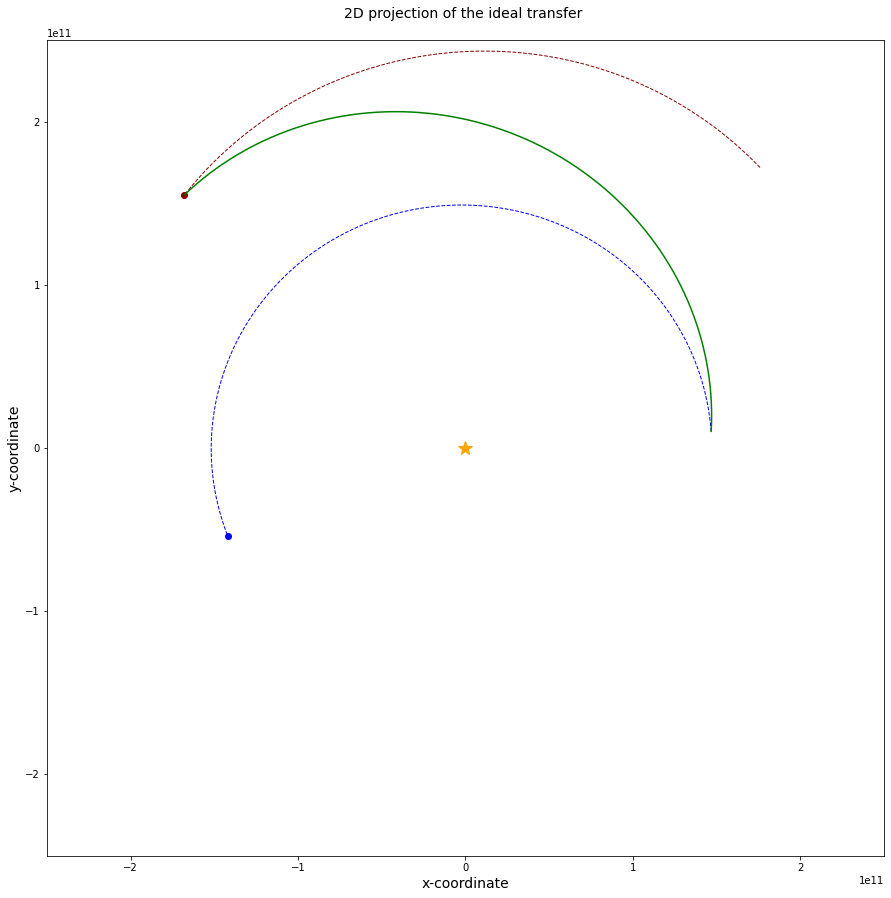

In [107]:
# AND THEN TEST THE MODEL HERE!
#n=86832 #201 days in seconds / 200 =86832 time steps
dt= 200
n=86237   #  86391 for dt=200
earth.pos=np.array([1.46752468e+11,1.02862993e+10])
earth.vel=np.array([-2170.58006789, 30205.19101003])
mars.pos=np.array([1.75981803e+11, 1.72028095e+11])
mars.vel=np.array([-15161.81821574,  16232.64491727])
a=getAngle([0,-1], sun.pos,earth.pos)*PI/180 #angle between vertical and cun-earth line, need to know where the rocket launch is optimal
spinvelocity=earth.radius/earth.period*2*PI
rocket = Satellite("rocket", 2.8e+6,np.array([earth.pos[0]+np.sin(a)*earth.radius,earth.pos[1]-np.cos(a)*earth.radius]))
rocket.vel=np.array([earth.vel[0]+np.cos(a)*spinvelocity, earth.vel[1]+np.sin(a)*spinvelocity])
PEX=np.zeros(n)
PEY=np.zeros(n)
PMX=np.zeros(n)
PMY=np.zeros(n)
RX=np.zeros(n)
RY=np.zeros(n)
print(rocket.vel, "rocket vel")
print(earth.vel, "earth vel")
print(rocket.pos, 'rocket pos')
print(earth.pos, 'earth pos')
#test the rocket velocity and compare it to earth's check


V=np.array([10871.66892004,  3617.3916524 ])  # [10847.  3659.] 443216866.8    [10847.    3658.75] 445563990.3267148

diff=10e+20
#input vector delat V, the additional velocity
rocket.vel = rocket.vel+V
for i in range(0,n): 
    RK4_nbody(earth,sun,mars,rocket,dt)
    RK4_nbody(mars,sun,rocket,earth,dt)
    RK4_nbody(rocket,sun,earth,mars,dt)
    RX[i]=rocket.pos[0]
    RY[i]=rocket.pos[1]
    PEX[i]=earth.pos[0]
    PEY[i]=earth.pos[1]
    PMX[i]=mars.pos[0]
    PMY[i]=mars.pos[1]
    #if np.linalg.norm(mars.pos-rocket.pos)>diff:
     #   print('closest approach', i-1)
      #  break
    if np.linalg.norm(earth.pos-rocket.pos)<earth.radius:
        print("crash launch")
        break
    if np.linalg.norm(rocket.pos-mars.pos)<mars.radius:
        print("mars crash", i)
        break
    diff=np.linalg.norm(mars.pos-rocket.pos)

fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot(111)
ax.plot(PMX,PMY, color="darkred", linewidth=1, linestyle="dashed" )
ax.plot(PEX,PEY, color="blue", linewidth=1, linestyle="dashed" )
ax.plot(0,0,label='Sun', marker="*", markersize=15, color="orange", linewidth=0)
ax.scatter(PMX[i],PMY[i], label="Mars", color="darkred")#, marker="o",s=80)
ax.scatter(PEX[i],PEY[i], label='Earth', color="blue") #, marker="o",s=80)
ax.plot(RX,RY, label='rocket', color="green")

ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_title("2D projection of the ideal transfer \n ",fontsize=14)
#ax.legend(loc="upper right",fontsize=14)
plt.ylim([-2.5e+11, 2.5e+11])
plt.xlim([-2.5e+11,2.5e+11])

In [116]:
print("dt=", dt)
print("dv1=",np.linalg.norm(V))
print("dv2=",np.linalg.norm(mars.vel-rocket.vel))
print(np.linalg.norm(rocket.vel))
print('dvtot=', np.linalg.norm(V)+np.linalg.norm(mars.vel-rocket.vel))

dt= 200
dv1= 11457.692065761625
dv2= 7439.9038169842215
18420.201530129776
dvtot= 18897.595882745845


In [109]:
print(np.linalg.norm(rocket.pos-mars.pos))     #96287425

5061034.263766097


In [41]:
#96287425      86254    200
#170604835357  8638     2000
#181521346532  4320     4000
#146301785119  17280.   1000
#97466612418   34560    500
#75882187598   43200.   400
#75882187598   57600    300
#61503949102  172508   100
#90921855886   345016   50

In [48]:
print(i)

8638


In [23]:
print(np.linalg.norm(mars.vel-rocket.vel))

4286.437455991777


In [84]:
XBOUNDS=[10860.00,10900.0]  
YBOUNDS=[3600.0,3650.0]
V=np.array([10866.12424588,  3627.30215907])
bnds=(XBOUNDS,YBOUNDS)
minimize(objective, V, bounds=bnds)    #[10871.66892004,  3617.3916524 ]

      fun: 47.203957799651185
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.31051235e+09, 4.67764609e+08])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1110
      nit: 96
     njev: 370
   status: 2
  success: False
        x: array([10871.66892004,  3617.3916524 ])

In [14]:
import numpy as np
print(np.linalg.norm([10866.12424588,  3627.30215907]))      #[10871.66892004,  3617.3916524 ]

11455.565332190949


In [71]:
np.savetxt("dtx50.txt", RX)
np.savetxt("dty50.txt",RY)

In [74]:
np.savetxt("dtx100.txt", RX)
np.savetxt("dty100.txt",RY)


In [76]:
np.savetxt("dtx400.txt",RX)
np.savetxt("dty400.txt",RY)

In [78]:
x400=np.loadtxt("dtx400.txt")
y400=np.loadtxt("dty400.txt")
x100=np.loadtxt("dtx100.txt")
y100=np.loadtxt("dty100.txt")
x50=np.loadtxt("dtx50.txt")
y50=np.loadtxt("dty50.txt")


Text(0.5, 1.0, 'Trajectories with the same launch velocity but different timesteps')

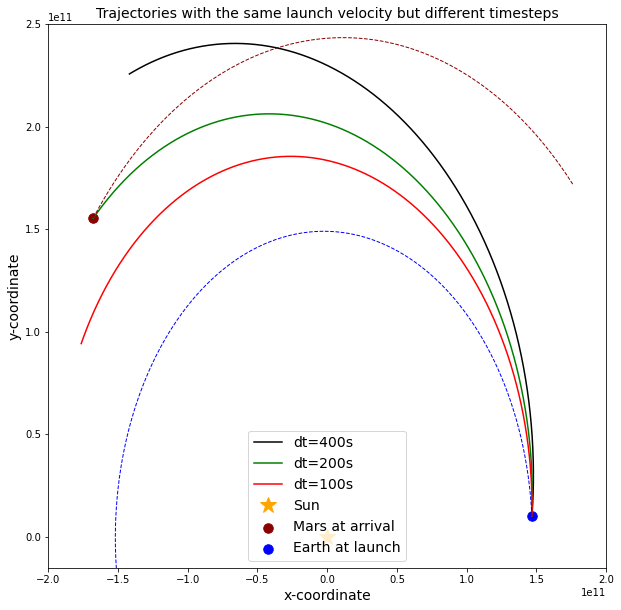

In [115]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(x400,y400, color="black", label="dt=400s")
ax.plot(RX,RY, color="green", label="dt=200s")
ax.plot(x100,y100, color="red", label="dt=100s")
#ax.plot(x50,y50, color="red", label="dt=50s")
ax.plot(PMX,PMY, color="darkred", linewidth=1, linestyle="dashed" )
ax.plot(PEX,PEY, color="blue", linewidth=1, linestyle="dashed" )
ax.plot(0,0,label='Sun', marker="*", markersize=17, color="orange", linewidth=0)
ax.scatter(PMX[i],PMY[i], label="Mars at arrival", color="darkred", marker="o",s=90)
ax.scatter(PEX[0],PEY[0], label='Earth at launch', color="blue", marker="o",s=90)
#ax.title("trajectories with the same launch velocities and different timesteps")
ax.legend(loc="best",fontsize=14)
plt.xlim([-2.0e+11, 2.0e+11])
plt.ylim([-0.15e+11,2.5e+11])
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_title("Trajectories with the same launch velocity but different timesteps",fontsize=14)
